In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from tqdm import tqdm
from sklearn import preprocessing



131.7581949765858

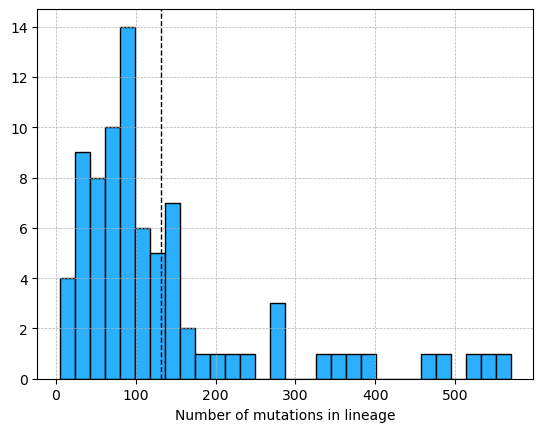

In [5]:
a= np.linspace(5, 570, 30)
b = np.array([4,9,8,10,14,6,5,7,2,1,1,1,1,0,3,0,0,1,1,1,1,0,0,0,1,1,0,1,1,1])

plt.hist(a, bins=30,  weights=b, facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations in lineage')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.axvline((a * b).sum()/b.sum(), color='k', linestyle='dashed', linewidth=1)
(a * b).sum()/b.sum()




282.1610501567398

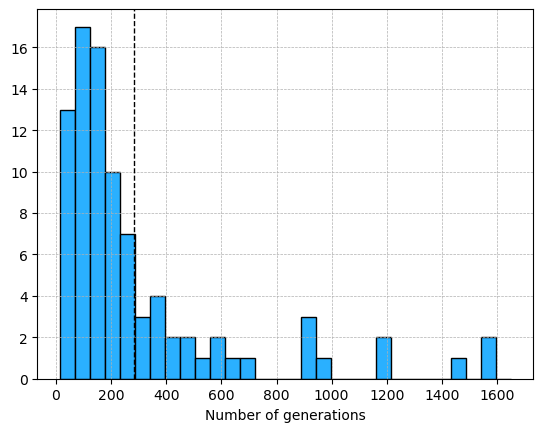

In [4]:
a = np.linspace(15, 1650, 30)
b = np.array([13, 17, 16, 10, 7, 3, 4, 2, 2, 1, 2, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0])


plt.hist(a, bins=30,  weights=b, facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of generations')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.axvline((a * b).sum()/b.sum(), color='k', linestyle='dashed', linewidth=1)

(a * b).sum()/b.sum()


In [ ]:
df = pd.DataFrame()
lineage_dict = {}
bestlog_dict = {}
log_dict = {}

workdir = "../../fold_nucleation_time/"
for log in tqdm(os.listdir(workdir)):
    path = os.path.join(workdir, log)
    if log.startswith('pfe50') and os.path.isdir(path) :
        lineage = pd.read_csv(workdir + log + '/visual_pfes_results/lineage.dat', sep=' ', comment='#')
        bestlog = pd.read_csv(workdir + log + '/visual_pfes_results/bestlog.tsv', sep='\t', comment='#')
        progresslog = pd.read_csv(workdir + log + '/progress.log', sep='\t', comment='#')

        lineage_dict[log] = lineage.dropna()
        bestlog_dict[log] = bestlog
        log_dict[log] = progresslog

In [7]:
lineage_lens = ([len(lineage_dict[f'pfe50_{i}']) for i in range(1,101)])
bestlog_lens = ([len(bestlog_dict[f'pfe50_{i}']) for i in range(1,101)])
log_lens = ([len(log_dict[f'pfe50_{i}']) for i in range(1,101)])

all_lineage = pd.concat([lineage_dict[f'pfe50_{i}']for i in range(1,101)])
all_bestlog= pd.concat([bestlog_dict[f'pfe50_{i}']for i in range(1,101)])
all_log= pd.concat([log_dict[f'pfe50_{i}']for i in range(1,101)])

print(f'len all_lineage {len(all_lineage)} \nlen all_bestlog {len(all_bestlog)} \nlen all_log {len(all_log)}')

len all_lineage 43781 
len all_bestlog 151908 
len all_log 15191600


# Correlations and distributions

In [8]:
correl_dict = {}
for pfe in lineage_dict.keys():
    df = lineage_dict[pfe]
    df = df[df.NA < 100]
    if len(df) > 3:
        x = df.score
        y = df.NA
        correl_dict[pfe] = pearsonr(x, y)[0]
print("mean correlation between rosetta and pfes score is", np.array(list(correl_dict.values())).mean())


mean correlation between rosetta and pfes score is -0.4700591970003506


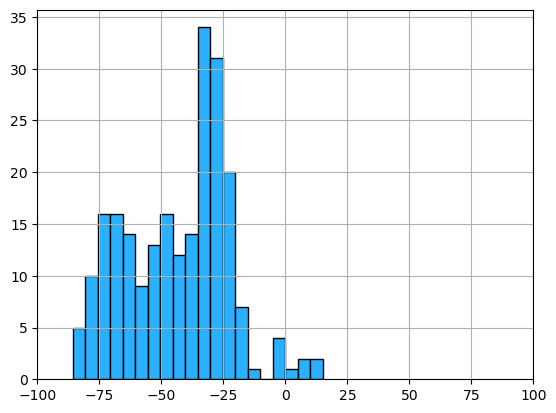

In [24]:
plt.style.use('default')

# histogram on linear scale
hist, bins, _ = plt.hist(lineage.NA, bins=20,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlim(-100,100)
plt.grid(True, which="both")



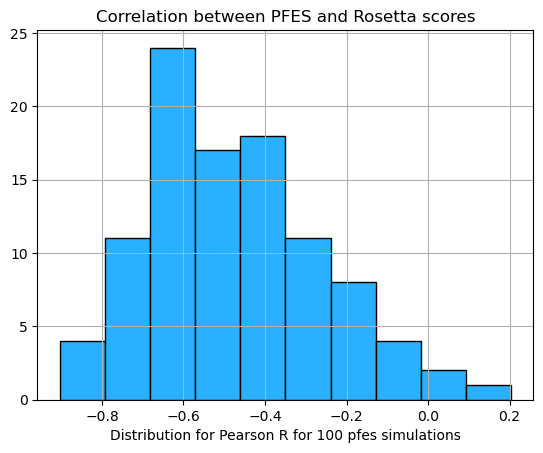

In [25]:
plt.style.use('default')
hist, bins, _ = plt.hist(correl_dict.values(), bins=10,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.title('Correlation between PFES and Rosetta scores')
plt.xlabel('Distribution for Pearson R for 100 pfes simulations')
plt.grid(True, which="both")



In [26]:
correl_df = pd.DataFrame({'name':list(correl_dict.keys()), 'correl':list(correl_dict.values())})
correl_df.sort_values('correl')

,name,correl
99,pfe50_99,-0.902763
97,pfe50_97,-0.835541
11,pfe50_19,-0.828937
49,pfe50_53,-0.825281
35,pfe50_40,-0.788182
...,...,...
55,pfe50_59,-0.068914
33,pfe50_39,-0.044950
5,pfe50_13,0.018451
20,pfe50_27,0.028031


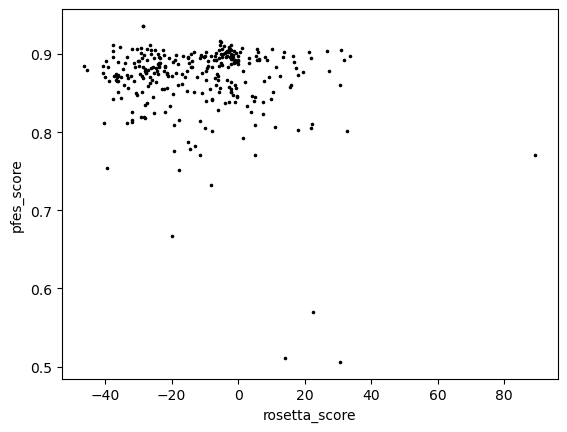

PearsonRResult(statistic=-0.15880814343445343, pvalue=0.0062682875116317725)


In [27]:
df = lineage_dict['pfe50_27']
df = df.dropna()
df = df[df.NA <100]
x = df.NA
y = df.mean_plddt
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c='black', s=10, marker='.')
plt.xlabel("rosetta_score")
plt.ylabel("pfes_score")
plt.show()
print(pearsonr(x, y))


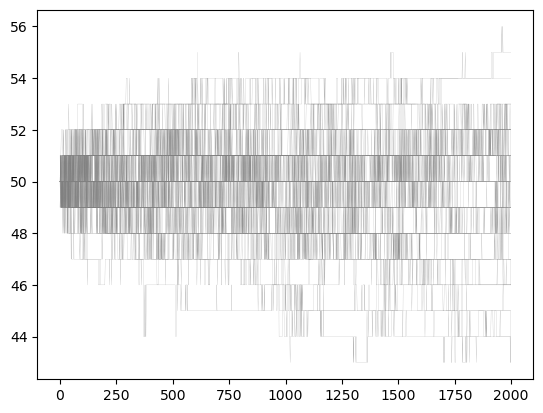

In [28]:
for pfe in bestlog_dict.keys():
    plt.plot(bestlog_dict[pfe].seq_len, '-', c='grey', linewidth=0.1)

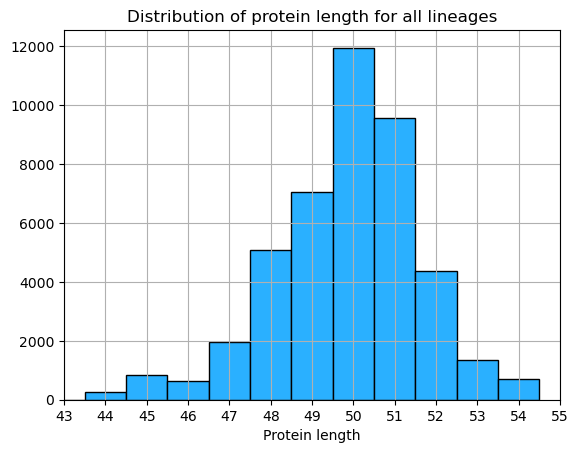

In [29]:
hist, bins, _ = plt.hist(all_lineage.seq_len-0.5, bins=12,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1 )
plt.xticks(range(40,60))
plt.xlim(43,55)
plt.title('Distribution of protein length for all lineages')
plt.xlabel('Protein length')

plt.grid(True, which="both")

In [30]:
print((all_bestlog.seq_len<50).sum())
print((all_bestlog.seq_len>50).sum())
print((all_lineage.seq_len==50).sum())

55684
53447
11957


In [34]:
lineage_tails = [] 
for pfe in lineage_dict.keys():
    #hist, bins, _ = plt.hist(
        t  = lineage_dict[pfe].iloc[-1].seq_len
        lineage_tails.append(t)
lineage_tails  = np.array(lineage_tails) 

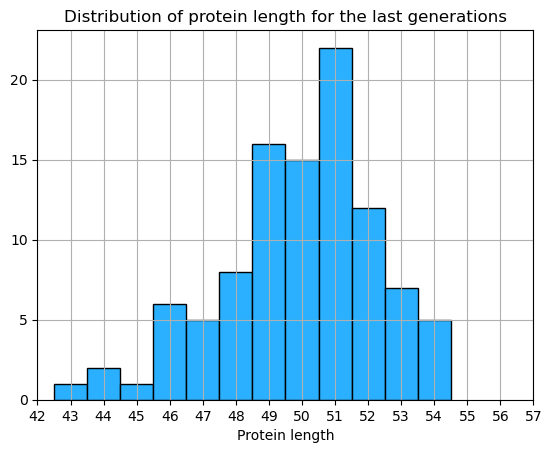

In [35]:
hist, bins, _ = plt.hist(lineage_tails-0.5, bins=12,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1 )
plt.xticks(range(40,60))
plt.xlim(42,57)
plt.title('Distribution of protein length for the last generations')
plt.xlabel('Protein length')
plt.grid(True, which="both")

In [36]:
print(len(lineage_tails[lineage_tails < 50]))
print(len(lineage_tails[lineage_tails > 50]))
print(len(lineage_tails[lineage_tails == 50]))

39
46
15


In [37]:
print(lineage_tails[lineage_tails < 50].sum())
print(lineage_tails[lineage_tails > 50].sum())


1855
2389


# AA composition

In [38]:
alphabet = list('ACDEFGHIKLMNPQRSTVWY')


one2three = {'C': 'CYS', 'D': 'ASP', 'S': 'SER', 'Q': 'GLN', 'K': 'LYS',
             'I': 'ILE', 'P': 'PRO', 'T': 'THR', 'F': 'PHE', 'N': 'ASN', 
             'G': 'GLY', 'H': 'HIS', 'L': 'LEU', 'R': 'ARG', 'W': 'TRP', 
             'A': 'ALA', 'V': 'VAL', 'E': 'GLU', 'Y': 'TYR', 'M': 'MET'}


three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
             'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
             'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
             'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

one2three ={}

uniprot = {'amino_acid': ['Leu', 'Ala', 'Gly', 'Val', 'Ser', 'Glu', 'Arg', 'Thr', 'Ile', 'Asp', 'Pro', 'Lys', 'Phe', 'Gln', 'Asn', 'Tyr', 'Met', 'His', 'Cys', 'Trp'],
'percent': [9.84, 9.00, 7.26, 6.86, 6.85, 6.25, 5.85, 5.56, 5.52, 5.48, 5.01, 4.95, 3.88, 3.81, 3.80, 2.88, 2.33, 2.23, 1.30, 1.30]}

#https://www.uniprot.org/uniprotkb/statistics#amino-acid-composition
swissprot = {'amino_acid': ['Leu', 'Ala', 'Gly', 'Val', 'Glu', 'Ser', 'Ile', 'Lys', 'Arg', 'Asp', 'Thr', 'Pro', 'Asn', 'Gln', 'Phe', 'Tyr', 'Met', 'His', 'Cys', 'Trp'],
'percent': [9.65, 8.26, 7.07, 6.86, 6.72, 6.65, 5.91, 5.80, 5.53, 5.46, 5.36, 4.75, 4.06, 3.93, 3.87, 2.92, 2.41, 2.28, 1.39, 1.10]}	

color_code_full = {'AA': ['A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'K',  'L',  'M',  'N',  'P',  'Q',  'R',  'S',  'T',  'V',  'W',  'Y'], 
                           'color': ['BLUE', 'PINK', 'MAGENTA', 'MAGENTA', 'BLUE', 'ORANGE', 'CYAN', 'BLUE', 'RED', 'BLUE',
                                      'BLUE', 'GREEN', 'GOLD', 'GREEN', 'RED', 'GREEN', 'GREEN', 'BLUE', 'BLUE', 'CYAN'], 
                           'feature': ['Hydrophobic', 'Cysteines', 'Negative_charge', 'Negative_charge', 'Hydrophobic', 
                                       'Glycines', 'Aromatic', 'Hydrophobic', 'Positive_charge', 'Hydrophobic', 'Hydrophobic', 
                                       'Polar', 'Prolines', 'Polar', 'Positive_charge', 'Polar', 'Polar', 'Hydrophobic', 'Hydrophobic', 'Aromatic' ]}

color_code = {AA:color for AA, color in zip(color_code_full['AA'], color_code_full['color'])}


dfUP = pd.DataFrame(uniprot).sort_values('amino_acid')
dfSP = pd.DataFrame(swissprot).sort_values('amino_acid')
resdata = pd.DataFrame({'amino_acid': dfUP.amino_acid, 'UPpercent': dfUP.percent, 'SPpercent': dfSP.percent})
resdata.insert(loc=0, column='AA', value=[three2one[AA] for AA in resdata.amino_acid.str.upper()])
resdata_sorted = resdata.sort_values('AA')


In [39]:
seqstrs = all_log[(all_log.ptm > 0.7) & (all_log.mean_plddt > 0.7)].sequence.str #.drop_duplicates('sequence')
len(seqstrs.len())

6323380

In [40]:
AAoccurance = {AA: seqstrs.count(AA).sum() for AA in alphabet} 
n_allAA = sum(AAoccurance.values())
pfes_percent = {AA:round((AAoccurance[AA]/n_allAA) * 100, 3) for AA in AAoccurance}

In [43]:
codonrates = {'A' : 4,  'C' : 2,  'D' : 2,  'E' : 2,  
              'F' : 2,  'G' : 4,  'H' : 2,  'I' : 3,  
              'K' : 2,  'L' : 6,  'M' : 1,  'N' : 2,  
              'P' : 4,  'Q' : 2,  'R' : 6,  'S' : 6,  
              'T' : 4,  'V' : 4,  'W' : 1,  'Y' : 2
              }

resdata_sorted['pfes_percent'] = pfes_percent.values()
resdata_sorted.reset_index(inplace = True, drop=True )
resdata_sorted['codonr'] = codonrates.values()

PearsonRResult(statistic=0.8084258300321011, pvalue=1.6087134058254037e-05)


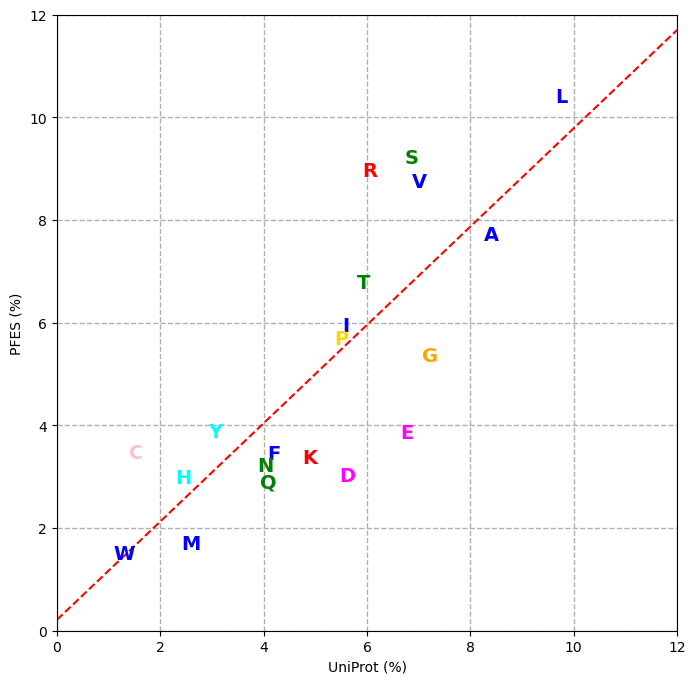

In [44]:
x = resdata_sorted.SPpercent
y = resdata_sorted.pfes_percent



fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.scatter(x, y, s=0)
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_xlabel('UniProt (%)')
ax.set_ylabel('PFES (%)')

for i, res in enumerate(resdata_sorted.AA):
    ax.annotate(res, (x[i], y[i]), c = color_code[res], fontsize=14, weight='bold')

m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1], 100)
plt.plot(X_plot, m*X_plot + b, '--', color='red')
plt.grid(True, which="both",linestyle='--', linewidth=1)
print(pearsonr(list(resdata_sorted.SPpercent), list(resdata_sorted.pfes_percent)))


# Substitution matrix 

In [55]:
matrix_log = all_log
mutations_list = list(matrix_log[(matrix_log.mutation.str.contains('\.')) & (matrix_log.mean_plddt > 0.85) & (matrix_log.ptm > 0.75)].mutation) #.drop_duplicates('sequence')
subst_list = [(m[0],m[-1]) for m in mutations_list]
len(subst_list)

1602144

In [51]:

matrix=np.empty((20,20))
for a, i in zip(alphabet,range(20)):
    for b, j in zip(alphabet,range(20)):
        matrix[i][j] = subst_list.count((a,b))

for i in range(20): matrix[i][i] = 0.1 

matrix = matrix/matrix.max()


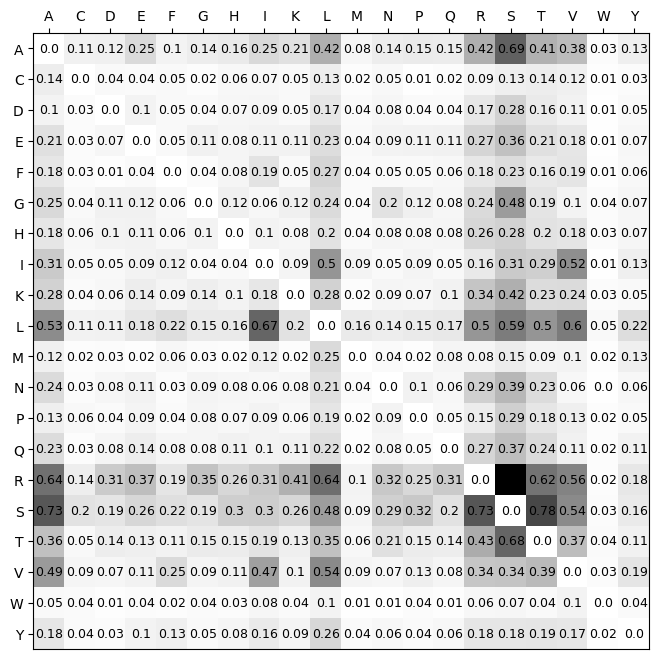

In [52]:
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.imshow((matrix), cmap='Greys')
ax.xaxis.tick_top()
ticks = alphabet
plt.setp(ax, xticks=range(20), xticklabels=ticks, yticks=range(20), yticklabels=ticks)

for (j,i),label in np.ndenumerate(matrix):
    ax.text(i,j,round(label,2),ha='center',va='center', size=9)


In [ ]:
matrix2 = matrix.copy()
matrix2[matrix2 == 0] = matrix.max()

# 

# Fold nucleation time

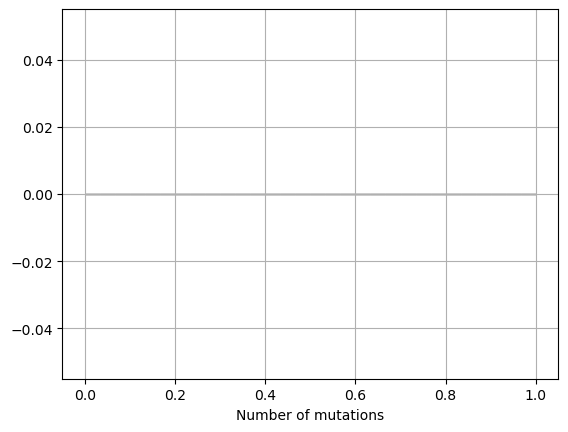

In [6]:
lineage_len = {}
for pfe in lineage_dict.keys():
    lineage_len[pfe] = len(lineage_dict[pfe])
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(lineage_len.values(), bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations')
plt.grid(True, which="both")



In [183]:
lineage_time = {}
for pfe in lineage_dict.keys():
    df=lineage_dict[pfe]
    dfmusk = (df.NA < -50) & (df.ptm > 0.75) & (df.mean_plddt > 0.85)
    if dfmusk.any():
        lineage_time[pfe] = (df[dfmusk].index[0])
print(len(lineage_time))


81


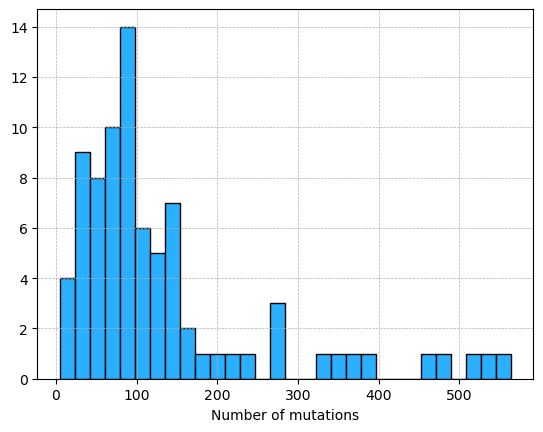

In [191]:
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(lineage_time.values(), bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [160]:
log_time = []
for pfe in bestlog_dict.keys():
    df=bestlog_dict[pfe]
    dfmusk = (df.mean_plddt > 0.85) & (df.ptm > 0.75)
    if dfmusk.any():
        log_time.append(df[dfmusk].index[0])
print(len(log_time))

88


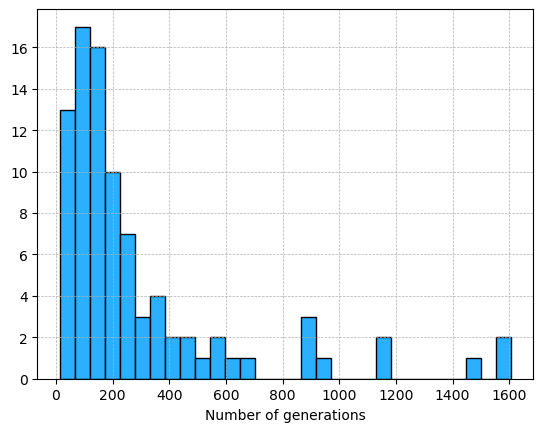

In [190]:
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(log_time, bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Number of generations')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [66]:
lineage_tails = {}
for pfe in lineage_dict.keys():
    #hist, bins, _ = plt.hist(
        t  = lineage_dict[pfe].iloc[-1].ss
        lineage_tails[pfe] = t
lineage_tails  = np.array(lineage_tails) 

'pfe50_10'

In [87]:
all_ss = ''.join(list(lineage_tails.values()))
n_h = all_ss.count('H')
n_e = all_ss.count('E')
n_c = all_ss.count('C')


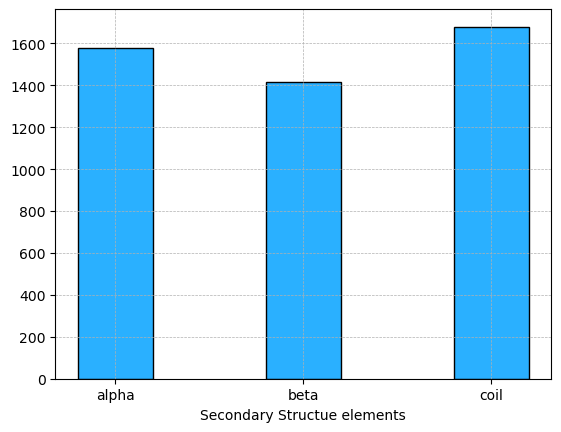

In [126]:
plt.style.use('default')
plt.bar(['alpha','beta', 'coil'],[n_h, n_e, n_c] , width = 0.4,facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Secondary Structue elements')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [100]:
mixed = 0
alpha = 0
beta = 0
for ss in list(lineage_tails.values()):
    if ('H' in ss) & ('E' in ss):
        mixed +=1
    if ('H' in ss) & ('E' not in ss):
        alpha +=1
    if ('H' not in  ss) & ('E' in ss):
        beta +=1


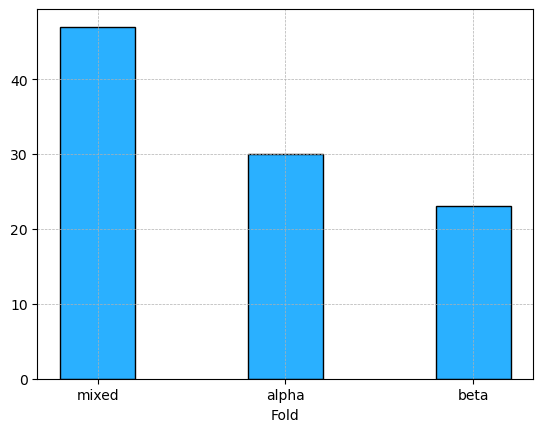

In [125]:
plt.style.use('default')
plt.bar(['mixed','alpha','beta'],[mixed, alpha, beta] , width = 0.4,facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Fold')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [193]:
df = pd.DataFrame({'names':list(lineage_time.keys()), 'nmut':list(lineage_time.values())})
df.sort_values('nmut').tail(20)

,names,nmut
51,pfe50_70,152
67,pfe50_87,153
22,pfe50_35,161
40,pfe50_56,172
80,pfe50_99,179
11,pfe50_21,207
50,pfe50_68,221
52,pfe50_72,244
33,pfe50_49,272
56,pfe50_76,277
